<a href="https://colab.research.google.com/github/thomas-greig/MSc/blob/main/NRNumba_select.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

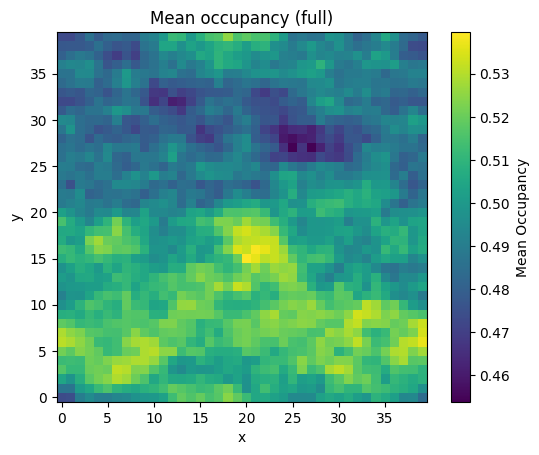

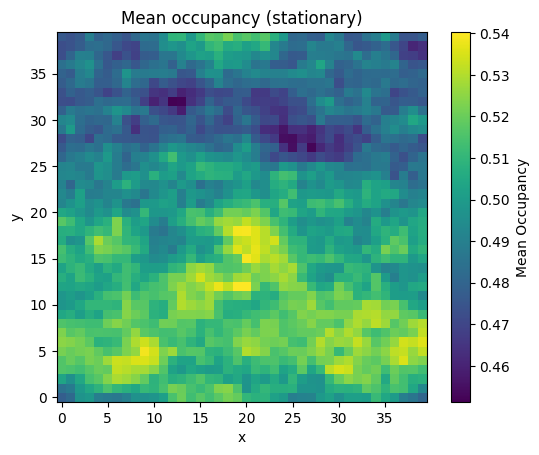

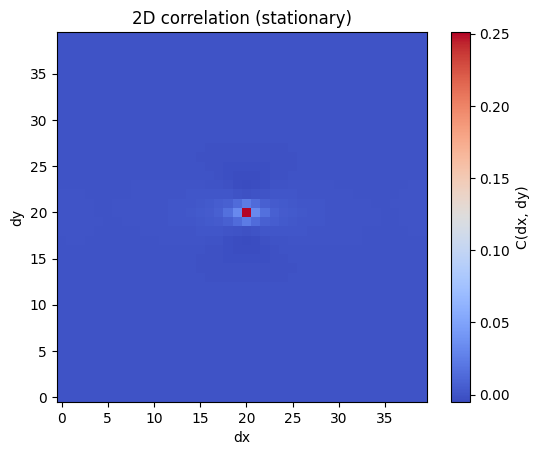

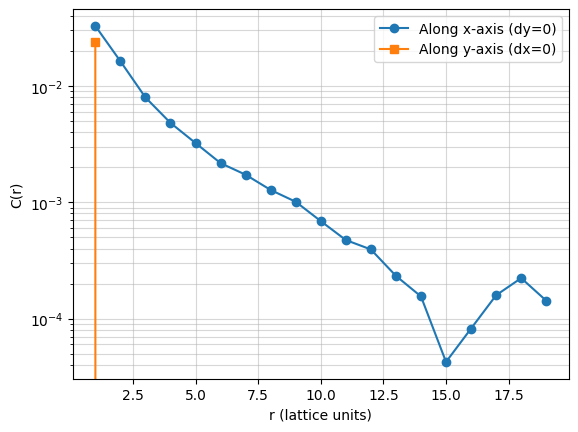

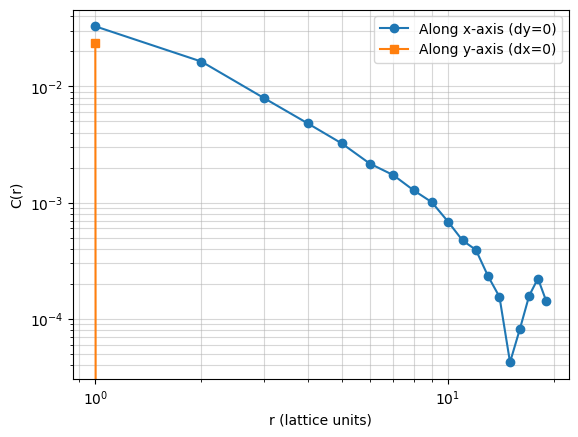

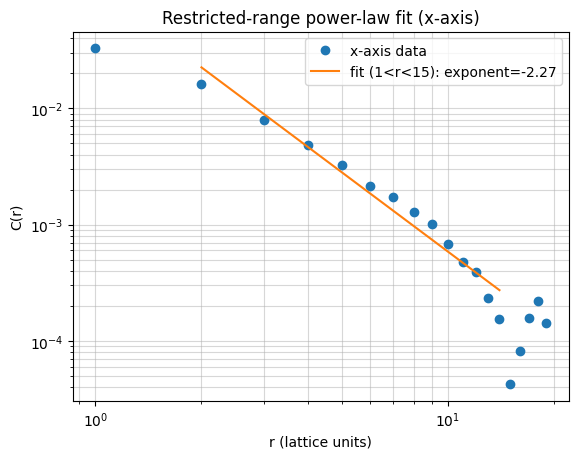

Power-law exponents (log-log linear fit over all positive points):
  X-axis slopes (20 runs): [-1.6623 -1.5142 -1.6349 -1.8801 -1.6211 -1.669  -1.7145 -2.2902 -1.5344
 -1.4864 -2.3397 -2.0947 -1.7305 -1.799  -2.1486 -1.9341 -1.3227 -1.6918
 -1.2951 -2.18  ]
  Y-axis slopes (20 runs): [    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan -6.9034     nan
     nan     nan]
  Mean±SD X: -1.7772 ± 0.3036
  Mean±SD Y: -6.9034 ± 0.0000
  Mean R^2 X: 0.9575 | Mean R^2 Y: 1.0000

Restricted-range fit on x-axis (1 < r < 15):
  Exponents (20 runs): [-1.6983 -1.8203 -1.7389 -1.9255 -1.6755 -1.7808 -1.8999 -2.4404 -1.7021
 -1.633  -2.3449 -2.4362 -1.8897 -1.7862 -1.9088 -1.9757 -1.4425 -1.8605
 -1.5202 -2.2656]
  Mean±SD: -1.8872 ± 0.2838


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from numpy.fft import fft2, ifft2, fftshift

# --------------------
# Toggle
# --------------------
USE_NUMBA = True   # set False to force the pure-Python fallback
DO_PLOTS  = True   # only the last run plots

# =========================
# Global Parameters
# =========================
Lx, Ly = 40, 40
N = 800
steps = 15_000_000           # total single-particle updates target
b_over_T = 4.0               # β/T
J_over_T = b_over_T/3.0      # J/T
eps = 0.8
drift_direction = (1, 0)     # (dx_bias, dy_bias)
sample_every = 800
relaxation_index = int(0.2 * steps / sample_every)

runs = 20
base_seed = 52341

# =========================
# Helpers
# =========================
def compute_2D_correlation(data):
    T, Lx_, Ly_ = data.shape
    mean_n = data.mean(axis=0)
    fluct = data - mean_n
    corr_fft = np.zeros((Lx_, Ly_), dtype=np.complex128)
    for frame in fluct:
        f = fft2(frame)
        corr_fft += f * np.conj(f)
    corr = np.real(ifft2(corr_fft)) / (T * Lx_ * Ly_)
    return fftshift(corr)

def plot_directional_cuts(corr, log_log=False):
    Lx_, Ly_ = corr.shape
    cx, cy = Lx_ // 2, Ly_ // 2
    cut_x = corr[cx:, cy];  r_x = np.arange(0, len(cut_x))
    cut_y = corr[cx, cy:];  r_y = np.arange(0, len(cut_y))
    plt.figure()
    plt.plot(r_x[1:], cut_x[1:], 'o-', label='Along x-axis (dy=0)')
    plt.plot(r_y[1:], cut_y[1:], 's-', label='Along y-axis (dx=0)')
    if log_log:
        plt.xscale('log'); plt.yscale('log')
    else:
        plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.xlabel('r (lattice units)'); plt.ylabel('C(r)')
    plt.legend(); plt.show()

def do_fits_and_plots(occupancy_time_series, do_plots=False):
    stationary = occupancy_time_series[relaxation_index:]
    corr_2d = compute_2D_correlation(stationary)

    # Directional cuts and log-log fits (all positive points)
    Lx_, Ly_ = corr_2d.shape
    cx, cy = Lx_ // 2, Ly_ // 2
    cut_x = corr_2d[cx:, cy];  r_x = np.arange(0, len(cut_x))
    cut_y = corr_2d[cx, cy:];  r_y = np.arange(0, len(cut_y))

    pos_x = cut_x[1:] > 0
    pos_y = cut_y[1:] > 0

    slope_x = np.nan; slope_y = np.nan
    r2_x = np.nan; r2_y = np.nan

    if np.count_nonzero(pos_x) >= 2:
        log_r_x = np.log(r_x[1:][pos_x])
        log_cut_x = np.log(cut_x[1:][pos_x])
        slope_x, intercept_x, r_value_x, _, _ = linregress(log_r_x, log_cut_x)
        r2_x = r_value_x**2

    if np.count_nonzero(pos_y) >= 2:
        log_r_y = np.log(r_y[1:][pos_y])
        log_cut_y = np.log(cut_y[1:][pos_y])
        slope_y, intercept_y, r_value_y, _, _ = linregress(log_r_y, log_cut_y)
        r2_y = r_value_y**2

    # Restricted fitting range on x-axis data
    exponent_range = np.nan
    if np.count_nonzero(pos_x) >= 2:
        r_x_full = r_x[1:][pos_x]
        cut_x_full = cut_x[1:][pos_x]
        fit_mask = (r_x_full > 1) & (r_x_full < 15)
        if np.count_nonzero(fit_mask) >= 2:
            log_r = np.log(r_x_full[fit_mask])
            log_C = np.log(cut_x_full[fit_mask])
            slope, intercept = np.polyfit(log_r, log_C, 1)
            exponent_range = slope

            if do_plots:
                mean_total = occupancy_time_series.mean(axis=0)
                mean_stationary = stationary.mean(axis=0)

                plt.imshow(mean_total.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
                plt.xlabel("x"); plt.ylabel("y"); plt.title("Mean occupancy (full)"); plt.show()

                plt.imshow(mean_stationary.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
                plt.xlabel("x"); plt.ylabel("y"); plt.title("Mean occupancy (stationary)"); plt.show()

                plt.imshow(corr_2d.T, origin='lower', cmap='coolwarm'); plt.colorbar(label='C(dx, dy)')
                plt.xlabel("dx"); plt.ylabel("dy"); plt.title("2D correlation (stationary)"); plt.show()

                plot_directional_cuts(corr_2d)
                plot_directional_cuts(corr_2d, log_log=True)

                # Log-log scatter + fit line for the restricted fit
                plt.figure()
                plt.loglog(r_x_full, cut_x_full, 'o', label="x-axis data")
                r_line = np.linspace(np.min(r_x_full[fit_mask]), np.max(r_x_full[fit_mask]), 200)
                C_line = np.exp(intercept) * r_line**slope
                plt.loglog(r_line, C_line, '-', label=f"fit (1<r<15): exponent={slope:.2f}")
                plt.xlabel("r (lattice units)"); plt.ylabel("C(r)")
                plt.legend(); plt.grid(True, which="both", ls="-", alpha=0.5)
                plt.title("Restricted-range power-law fit (x-axis)")
                plt.show()

    return corr_2d, slope_x, slope_y, exponent_range, r2_x, r2_y

# =========================
# Numba
# =========================
NUMBA_OK = False
if USE_NUMBA:
    try:
        from numba import njit
        NUMBA_OK = True
    except Exception:
        NUMBA_OK = False

# 5 moves: L, R, S, U, D
MOVES = np.array([[-1,0],[1,0],[0,0],[0,1],[0,-1]], dtype=np.int8)

# Precompute drift alignment for given drift_direction
dx_bias, dy_bias = drift_direction
DRIFT_ALIGN = (MOVES[:,0] * dx_bias + MOVES[:,1] * dy_bias).astype(np.int8)

if NUMBA_OK:
    @njit
    def nn_sum_numba(occ, x, y, Lx, Ly):
        return (occ[(x-1) % Lx, y] + occ[(x+1) % Lx, y] +
                occ[x, (y-1) % Ly] + occ[x, (y+1) % Ly])

    @njit
    def sample_move(u, w0, w1, w2, w3, w4):
        c = w0
        if u < c: return 0
        c += w1
        if u < c: return 1
        c += w2
        if u < c: return 2
        c += w3
        if u < c: return 3
        return 4

    @njit
    def one_sweep(positions, occupancy, Lx, Ly, b_over_T, J_over_T, eps, MOVES, DRIFT_ALIGN):
        N = positions.shape[0]
        order = np.arange(N)
        # Fisher-Yates shuffle
        for i in range(N-1, 0, -1):
            j = np.random.randint(0, i+1)
            order[i], order[j] = order[j], order[i]

        for t in range(N):
            idx = order[t]
            x_old = positions[idx,0]
            y_old = positions[idx,1]

            n_old = occupancy[x_old, y_old]
            S_old = nn_sum_numba(occupancy, x_old, y_old, Lx, Ly)

            # compute weights (unrolled to avoid tiny allocs)
            w0=w1=w2=w3=w4=0.0
            for m in range(5):
                dx = MOVES[m,0]; dy = MOVES[m,1]
                if dx == 0 and dy == 0:
                    dE = 0.0
                else:
                    x_trial = (x_old + dx) % Lx
                    y_trial = (y_old + dy) % Ly

                    n_trial = occupancy[x_trial, y_trial]
                    S_trial = nn_sum_numba(occupancy, x_trial, y_trial, Lx, Ly)

                    dE_on = 2.0 * b_over_T * (1.0 + (n_trial - n_old))
                    dE_nn = - J_over_T * ((S_trial - S_old) - 1.0)
                    drive = -float(DRIFT_ALIGN[m])
                    dE = dE_on + dE_nn + drive

                base_prob = 1.0 / (1.0 + np.exp(dE))   # sigmoid(dE)
                weight = (1.0 + eps * float(DRIFT_ALIGN[m])) * base_prob

                if m==0: w0=weight
                elif m==1: w1=weight
                elif m==2: w2=weight
                elif m==3: w3=weight
                else: w4=weight

            s = w0 + w1 + w2 + w3 + w4
            w0 /= s; w1 /= s; w2 /= s; w3 /= s; w4 /= s

            # sample
            u = np.random.random()
            m = sample_move(u, w0, w1, w2, w3, w4)

            dx = MOVES[m,0]; dy = MOVES[m,1]
            if dx != 0 or dy != 0:
                x_new = (x_old + dx) % Lx
                y_new = (y_old + dy) % Ly
                positions[idx,0] = x_new
                positions[idx,1] = y_new
                occupancy[x_old, y_old] -= 1
                occupancy[x_new, y_new] += 1

    @njit
    def simulate_numba(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, eps, seed, MOVES, DRIFT_ALIGN):
        if seed >= 0:
            np.random.seed(seed)

        positions = np.empty((N,2), dtype=np.int32)
        positions[:,0] = np.random.randint(0, Lx, size=N)
        positions[:,1] = np.random.randint(0, Ly, size=N)

        occupancy = np.zeros((Lx, Ly), dtype=np.int16)
        for i in range(N):
            occupancy[positions[i,0], positions[i,1]] += 1

        n_samples = steps // sample_every + 1
        series = np.zeros((n_samples, Lx, Ly), dtype=np.int16)
        sidx = 0
        series[sidx,:,:] = occupancy
        sidx += 1

        step = 0  # counts single-particle updates
        while step < steps:
            one_sweep(positions, occupancy, Lx, Ly, b_over_T, J_over_T, eps, MOVES, DRIFT_ALIGN)
            step += N
            while (sidx < n_samples) and (step >= sidx*sample_every):
                series[sidx,:,:] = occupancy
                sidx += 1
                if sidx >= n_samples:
                    break

        return series

# =========================
# Pure-Python fallback (slower)
# =========================
def nn_sum_py(occ, x, y):
    return occ[(x-1) % Lx, y] + occ[(x+1) % Lx, y] + occ[x, (y-1) % Ly] + occ[x, (y+1) % Ly]

def compute_2D_move_probabilities_py(positions, idx, occupancy, b_over_T, J_over_T, eps, MOVES, DRIFT_ALIGN):
    x_old, y_old = positions[idx]
    n_old = occupancy[x_old, y_old]
    S_old = nn_sum_py(occupancy, x_old, y_old)
    weights = np.empty(5, dtype=np.float64)

    for m in range(5):
        dx, dy = MOVES[m]
        if dx == 0 and dy == 0:
            dE = 0.0
        else:
            x_trial = (x_old + dx) % Lx
            y_trial = (y_old + dy) % Ly
            n_trial = occupancy[x_trial, y_trial]
            S_trial = nn_sum_py(occupancy, x_trial, y_trial)

            dE_on = 2.0 * b_over_T * (1.0 + (n_trial - n_old))
            dE_nn = - J_over_T * ((S_trial - S_old) - 1.0)
            drive = -float(DRIFT_ALIGN[m])
            dE = dE_on + dE_nn + drive

        base_prob = 1.0 / (1.0 + np.exp(dE))
        weights[m] = (1.0 + eps * float(DRIFT_ALIGN[m])) * base_prob

    probs = weights / np.sum(weights)
    # cumulative sample
    u = np.random.random()
    c = 0.0
    for k in range(5):
        c += probs[k]
        if u < c:
            m = k
            break
    dx, dy = MOVES[m]
    return dx, dy

def simulate_pure_python(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, eps, seed, MOVES, DRIFT_ALIGN):
    if seed is not None:
        np.random.seed(seed)

    positions = np.column_stack((
        np.random.randint(0, Lx, size=N),
        np.random.randint(0, Ly, size=N)
    )).astype(np.int32)
    occupancy = np.zeros((Lx, Ly), dtype=np.int16)
    for x, y in positions:
        occupancy[x, y] += 1

    n_samples = steps // sample_every + 1
    series = np.zeros((n_samples, Lx, Ly), dtype=np.int16)
    sidx = 0

    for t in range(steps):
        idx = np.random.randint(N)
        dx, dy = compute_2D_move_probabilities_py(positions, idx, occupancy, b_over_T, J_over_T, eps, MOVES, DRIFT_ALIGN)
        x_old, y_old = positions[idx]
        x_new = (x_old + dx) % Lx
        y_new = (y_old + dy) % Ly
        if dx != 0 or dy != 0:
            positions[idx,0] = x_new
            positions[idx,1] = y_new
            occupancy[x_old, y_old] -= 1
            occupancy[x_new, y_new] += 1

        if t % sample_every == 0:
            series[sidx] = occupancy
            sidx += 1
            if sidx >= n_samples:
                break

    return series

# =========================
# Run X times and aggregate
# =========================
results = []
all_series = []   # <-- stored time series for each run

for i in range(runs):
    seed = base_seed + i

    if NUMBA_OK:
        series = simulate_numba(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, eps, seed, MOVES, DRIFT_ALIGN)
    else:
        print("Numba not available or disabled — using slower pure-Python loop.")
        series = simulate_pure_python(Lx, Ly, N, steps, sample_every, b_over_T, J_over_T, eps, seed, MOVES, DRIFT_ALIGN)

    all_series.append(series)

    corr_2d, slope_x, slope_y, exponent_range, r2_x, r2_y = do_fits_and_plots(series, do_plots=(DO_PLOTS and (i == runs-1)))
    results.append({
        "slope_x": slope_x,
        "slope_y": slope_y,
        "exponent_range": exponent_range,
        "r2_x": r2_x,
        "r2_y": r2_y
    })

# =========================
# Report
# =========================
exponents_x = np.array([r["slope_x"] for r in results], dtype=float)
exponents_y = np.array([r["slope_y"] for r in results], dtype=float)
exponents_range = np.array([r["exponent_range"] for r in results], dtype=float)
r2_x_all = np.array([r["r2_x"] for r in results], dtype=float)
r2_y_all = np.array([r["r2_y"] for r in results], dtype=float)

def finite(arr):
    return arr[np.isfinite(arr)]

def stats(arr):
    a = finite(arr)
    if a.size == 0:
        return np.nan, np.nan
    return np.mean(a), np.std(a, ddof=1) if a.size > 1 else 0.0

mean_x, std_x = stats(exponents_x)
mean_y, std_y = stats(exponents_y)
mean_rng, std_rng = stats(exponents_range)
mean_r2x, _ = stats(r2_x_all)
mean_r2y, _ = stats(r2_y_all)

np.set_printoptions(precision=4, suppress=True)

print("Power-law exponents (log-log linear fit over all positive points):")
print(f"  X-axis slopes ({runs} runs): {exponents_x}")
print(f"  Y-axis slopes ({runs} runs): {exponents_y}")
print(f"  Mean±SD X: {mean_x:.4f} ± {std_x:.4f}")
print(f"  Mean±SD Y: {mean_y:.4f} ± {std_y:.4f}")
print(f"  Mean R^2 X: {mean_r2x:.4f} | Mean R^2 Y: {mean_r2y:.4f}")

print("\nRestricted-range fit on x-axis (1 < r < 15):")
print(f"  Exponents ({runs} runs): {exponents_range}")
print(f"  Mean±SD: {mean_rng:.4f} ± {std_rng:.4f}")


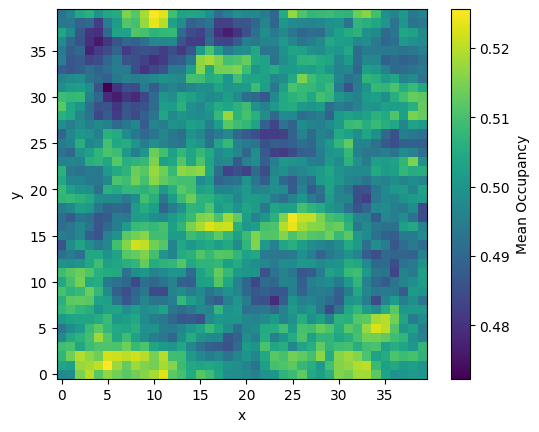

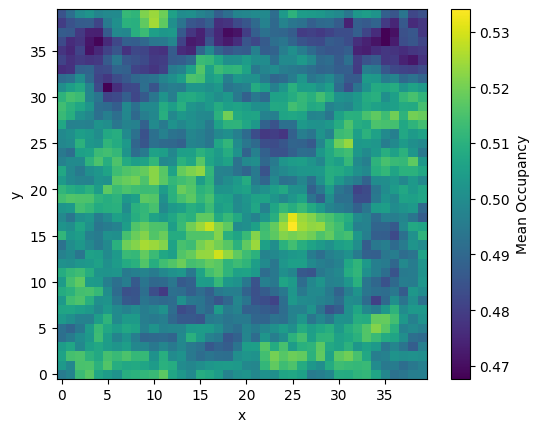

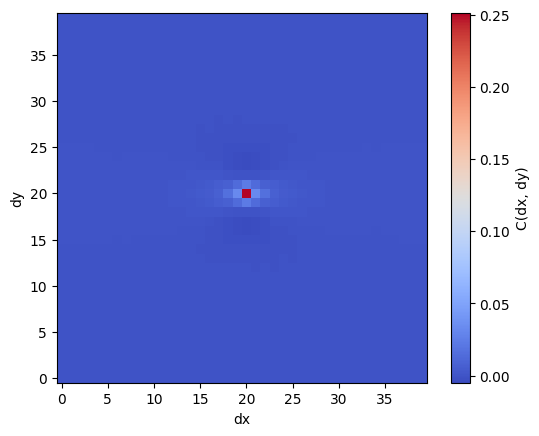

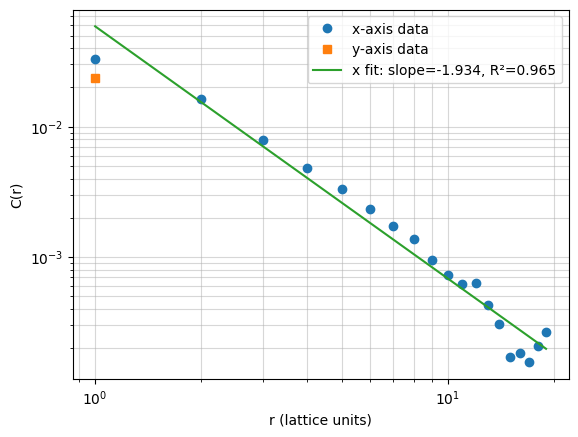

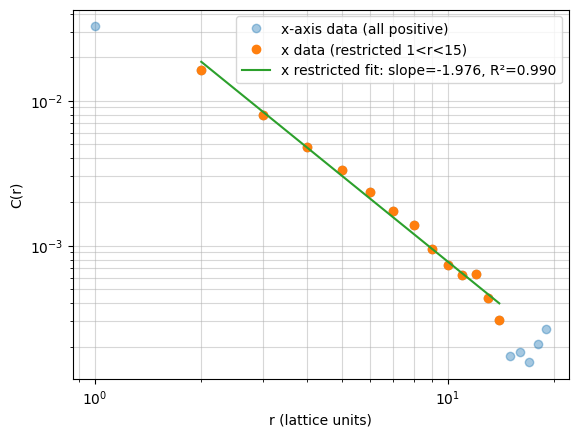

In [ ]:
# =========================
# Re-plot a specific run WITH linear fits
# =========================

# Choose which run to inspect (0 .. runs-1)
run_index = 15

# Restricted fit window for the x-axis (set to None to skip)
restricted_window = (1, 15)  # (r_min, r_max)

if not (0 <= run_index < len(all_series)):
    raise ValueError(f"run_index out of range. You have {len(all_series)} stored runs.")

series = all_series[run_index]

stationary = series[relaxation_index:]
corr_2d = compute_2D_correlation(stationary)

# --- Mean occupancy (full and stationary) ---
mean_total = series.mean(axis=0)
mean_stationary = stationary.mean(axis=0)

plt.imshow(mean_total.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y");  plt.show()

plt.imshow(mean_stationary.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y");  plt.show()

# --- 2D correlation map ---
plt.imshow(corr_2d.T, origin='lower', cmap='coolwarm'); plt.colorbar(label='C(dx, dy)')
plt.xlabel("dx"); plt.ylabel("dy");  plt.show()

# --- Directional cuts with log–log linear fits ---
Lx_, Ly_ = corr_2d.shape
cx, cy = Lx_ // 2, Ly_ // 2
cut_x = corr_2d[cx:, cy];  r_x = np.arange(0, len(cut_x))
cut_y = corr_2d[cx, cy:];  r_y = np.arange(0, len(cut_y))

# masks to avoid non-positive values at r>=1
pos_x = cut_x[1:] > 0
pos_y = cut_y[1:] > 0

def fit_powerlaw(r_vals, c_vals):
    """Return slope, intercept, r2; or (nan, nan, nan) if insufficient."""
    if r_vals.size >= 2:
        lr = np.log(r_vals); lc = np.log(c_vals)
        slope, intercept, r_value, _, _ = linregress(lr, lc)
        return slope, intercept, r_value**2
    return np.nan, np.nan, np.nan

# Full-range (all positive) fits
r_pos_x = r_x[1:][pos_x]; c_pos_x = cut_x[1:][pos_x]
r_pos_y = r_y[1:][pos_y]; c_pos_y = cut_y[1:][pos_y]

slope_x, intercept_x, r2_x = fit_powerlaw(r_pos_x, c_pos_x)
slope_y, intercept_y, r2_y = fit_powerlaw(r_pos_y, c_pos_y)

# Plot both cuts with fit lines (full positive range)
plt.figure()
plt.loglog(r_pos_x, c_pos_x, 'o', label='x-axis data')
plt.loglog(r_pos_y, c_pos_y, 's', label='y-axis data')

if np.isfinite(slope_x):
    rr = np.linspace(r_pos_x.min(), r_pos_x.max(), 200)
    plt.loglog(rr, np.exp(intercept_x) * rr**slope_x, '-',
               label=f'x fit: slope={slope_x:.3f}, R²={r2_x:.3f}')
if np.isfinite(slope_y):
    rr = np.linspace(r_pos_y.min(), r_pos_y.max(), 200)
    plt.loglog(rr, np.exp(intercept_y) * rr**slope_y, '-',
               label=f'y fit: slope={slope_y:.3f}, R²={r2_y:.3f}')

plt.xlabel('r (lattice units)')
plt.ylabel('C(r)')
#plt.title(f'Run {run_index}: directional cuts with full-range fits')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

# Optional: Restricted-range x-axis fit (e.g., 1 < r < 15)
if restricted_window is not None and r_pos_x.size:
    rmin, rmax = restricted_window
    mask = (r_pos_x > rmin) & (r_pos_x < rmax)
    slope_rx, intercept_rx, r2_rx = fit_powerlaw(r_pos_x[mask], c_pos_x[mask])

    plt.figure()
    # show all x data faint, highlight the fit window points
    plt.loglog(r_pos_x, c_pos_x, 'o', alpha=0.4, label='x-axis data (all positive)')
    if np.count_nonzero(mask) >= 2:
        plt.loglog(r_pos_x[mask], c_pos_x[mask], 'o', label=f'x data (restricted {rmin}<r<{rmax})')
        rr = np.linspace(r_pos_x[mask].min(), r_pos_x[mask].max(), 200)
        plt.loglog(rr, np.exp(intercept_rx) * rr**slope_rx, '-',
                   label=f'x restricted fit: slope={slope_rx:.3f}, R²={r2_rx:.3f}')
        ttl = f'Run {run_index}: x-axis restricted fit ({rmin}<r<{rmax})'
    else:
        ttl = f'Run {run_index}: x-axis restricted fit — insufficient points in ({rmin},{rmax})'

    plt.xlabel('r (lattice units)')
    plt.ylabel('C(r)')
    #plt.title(ttl)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()
    plt.show()
